# Process Instron data: tension, compression, and shear of 4x4 rotating square samples

NOTE: Please download data associated to this repository from https://doi.org/10.5281/zenodo.12823471


## Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from difflexmm.utils import save_data, load_data
from typing import List, Optional, Tuple, Dict
import itertools
from glob import glob
from pathlib import Path
plt.style.use(["science", "grid"])
%matplotlib widget


## Helper functions

In [33]:
def read_instron_data(path: str):
    time, displacement, force = np.loadtxt(
        path, skiprows=3, delimiter=",", unpack=True)
    return time, displacement, force


def resample(t, f, n_points):
    return np.interp(np.linspace(np.min(t), np.max(t), n_points), t, f)


def sanitize_force_displacement_data(data: Tuple[np.ndarray, np.ndarray, np.ndarray], force_threshold=0.0, u_lim: Optional[Tuple[float, float]] = None, n_sample_points=200):
    """
    Sanitize force-displacement data by:
    - Resampling uniformly
    - Chopping displacement between a certain range defined by u_lim
    """

    t, u, f = data  # time, displacement, force
    if force_threshold is not None:
        slice = np.where((f > force_threshold))
        offset_u = u[slice] - u[slice][0]
        # Resample uniformly
        u = resample(t[slice], offset_u, n_sample_points)
        f = resample(t[slice], f[slice], n_sample_points)

    # Chop beyond u_max
    if u_lim is not None:
        u_linear = np.linspace(*u_lim, n_sample_points)
        f = np.interp(u_linear, u, f)
        u = u_linear

    return u, f


def compute_mean_std(data: Dict[str, np.ndarray]):
    """
    Compute mean and standard deviation of the data across runs.

    Args:
        data (Dict[str, np.ndarray]): Dictionary of data with the following structure:
            {
                "test_name": np.array([
                    [displacement_array, force_array],
                    [displacement_array, force_array],
                    ...
                ]),
                ...
            }

    Returns:
        Dict[str, np.ndarray]: Dictionary of mean and standard deviation of the data with the following structure:
            {
                "test_name": np.array([displacement_array, mean_force_array, std_force_array]),
                ...
            }
    """

    return {test: np.array([test_data[0, 0, :], test_data[:, 1, :].mean(axis=0), test_data[:, 1, :].std(axis=0)]) for test, test_data in data.items()}

In [31]:

def plot_raw_force_displacement_curves(paths: List[str], figsize=(6, 3), **plot_kwargs):
    displacement = []
    force = []
    for file in paths:
        _, u, f = read_instron_data(file)
        displacement.append(u)
        force.append(f)

    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)

    for u, f in zip(displacement, force):
        axes.plot(u, f, **plot_kwargs)

    axes.set(xlabel="Displacement [mm]", ylabel="Force [N]")

    return fig, axes


def plot_raw_force_displacement_curves_all_samples(paths: List[List[str]], colors: Optional[List[str]] = None, figsize=(6, 3), **plot_kwargs):

    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)

    for i, sample in enumerate(paths):
        displacement = []
        force = []
        for file in sample:
            _, u, f = read_instron_data(file)
            displacement.append(u)
            force.append(f)

        color = colors[i] if colors is not None else None
        for u, f in zip(displacement, force):
            axes.plot(u, f, color=color, **plot_kwargs)

    axes.set(xlabel="Displacement [mm]", ylabel="Force [N]")

    return fig, axes


def plot_force_displacement_data(data: Dict[str, np.ndarray], figsize=(6, 3), **plot_kwargs):

    ncols = len(data.keys())
    fig, axes = plt.subplots(
        ncols=ncols, figsize=figsize, constrained_layout=True)

    for (key, uf_datas), ax in zip(data.items(), axes):
        for u, f in uf_datas:
            ax.plot(u, f, label=key, **plot_kwargs)
        ax.set(xlabel="Displacement [mm]", ylabel="Force [N]", title=key)

    return fig, axes


def plot_force_displacement_statistics(exp_data: Dict[str, np.ndarray], figsize=(6, 3), **plot_kwargs):
    ncols = len(exp_data.keys())
    fig, axes = plt.subplots(
        ncols=ncols, figsize=figsize, constrained_layout=True)

    for (key, (u, f, std)), ax in zip(exp_data.items(), axes):
        ax.plot(u, f, label=key, **plot_kwargs)
        ax.fill_between(u, f-std, f+std, alpha=0.5, **plot_kwargs)
        ax.set(xlabel="Displacement [mm]", ylabel="Force [N]", title=key)

    return fig, axes

## Paths

In [28]:
data_folder = Path("../../data/hinge_characterization_3dp_pla_shims")

## Raw data

### Compression

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Displacement [mm]', ylabel='Force [N]'>)

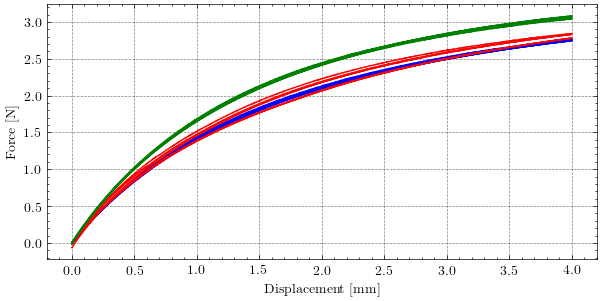

In [34]:
files_s1 = sorted(glob(f"{data_folder}/instron-data/compression_s1_*/*.txt"))
files_s2 = sorted(glob(f"{data_folder}/instron-data/compression_s2_*/*.txt"))
files_s3 = sorted(glob(f"{data_folder}/instron-data/compression_s3_*/*.txt"))
plot_raw_force_displacement_curves_all_samples([files_s1, files_s2, files_s3], colors=["blue", "red", "green"])

### Shear

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Displacement [mm]', ylabel='Force [N]'>)

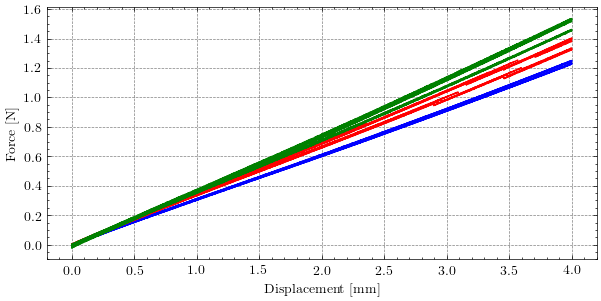

In [35]:
files_s1 = sorted(glob(f"{data_folder}/instron-data/shear_s1_*/*.txt"))
files_s2 = sorted(glob(f"{data_folder}/instron-data/shear_s2_*/*.txt"))
files_s3 = sorted(glob(f"{data_folder}/instron-data/shear_s3_*/*.txt"))
plot_raw_force_displacement_curves_all_samples([files_s1, files_s2, files_s3], colors=["blue", "red", "green"])

### Tension

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='Displacement [mm]', ylabel='Force [N]'>)

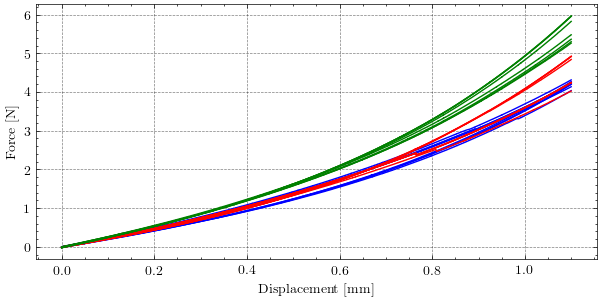

In [36]:
files_s1 = sorted(glob(f"{data_folder}/instron-data/tension_s1_*/*.txt"))
files_s2 = sorted(glob(f"{data_folder}/instron-data/tension_s2_*/*.txt"))
files_s3 = sorted(glob(f"{data_folder}/instron-data/tension_s3_*/*.txt"))
plot_raw_force_displacement_curves_all_samples([files_s1, files_s2, files_s3], colors=["blue", "red", "green"])

## Sanitize data

In [37]:
# NOTE: Adjust sample_labels and test_labels to match actual filenames
sample_labels = ["s1", "s2", "s3"]
test_labels = ["tension", "compression", "shear"]

# NOTE: Adjust these parameters to sanitize data
force_threshold = None
u_lim = ((0., 1.05), (0., 3.75), (0., 3.75))
n_sample_points = 200

# Load files
files = [
    [
        sorted(glob(f"{data_folder}/instron-data/{test}_{sample}*/*.txt"))
        for sample in sample_labels
    ]
    for test in test_labels
]

# Bundle all runs across samples
files = [list(itertools.chain(*file_samples)) for file_samples in files]

# Sanitize data and create dictionary with test labels as keys
# Each value is an array of shape (n_samples*n_runs, 2, n_sample_points)
sanitized_data = {k: [] for k in test_labels}
for i, test in enumerate(test_labels):
    for file in files[i]:
        u, f = sanitize_force_displacement_data(
            read_instron_data(file),
            force_threshold=force_threshold,
            n_sample_points=n_sample_points,
            u_lim=u_lim[i]
        )
        sanitized_data[test].append([u, f])
    sanitized_data[test] = np.array(sanitized_data[test])

sanitized_data

{'tension': array([[[ 0.00000000e+00,  5.27638191e-03,  1.05527638e-02, ...,
           1.03944724e+00,  1.04472362e+00,  1.05000000e+00],
         [ 0.00000000e+00,  9.69296482e-03,  2.05374372e-02, ...,
           3.63342281e+00,  3.66547320e+00,  3.70033333e+00]],
 
        [[ 0.00000000e+00,  5.27638191e-03,  1.05527638e-02, ...,
           1.03944724e+00,  1.04472362e+00,  1.05000000e+00],
         [ 1.70000000e-03,  1.22055276e-02,  2.15874372e-02, ...,
           3.78163457e+00,  3.81800000e+00,  3.85360000e+00]],
 
        [[ 0.00000000e+00,  5.27638191e-03,  1.05527638e-02, ...,
           1.03944724e+00,  1.04472362e+00,  1.05000000e+00],
         [-1.73000000e-02, -5.76218593e-03,  5.05276382e-03, ...,
           3.76995508e+00,  3.80586294e+00,  3.84185000e+00]],
 
        ...,
 
        [[ 0.00000000e+00,  5.27638191e-03,  1.05527638e-02, ...,
           1.03944724e+00,  1.04472362e+00,  1.05000000e+00],
         [-2.57000000e-02, -1.15338358e-02,  1.45276382e-03, ...,
   

## Plot sanitized data

(<Figure size 900x300 with 3 Axes>,
 array([<Axes: title={'center': 'tension'}, xlabel='Displacement [mm]', ylabel='Force [N]'>,
        <Axes: title={'center': 'compression'}, xlabel='Displacement [mm]', ylabel='Force [N]'>,
        <Axes: title={'center': 'shear'}, xlabel='Displacement [mm]', ylabel='Force [N]'>],
       dtype=object))

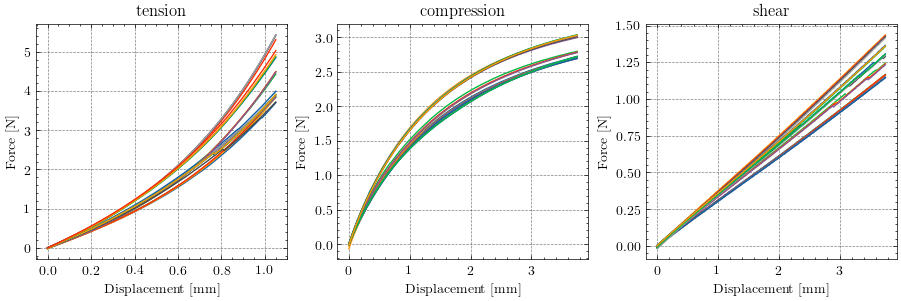

In [38]:
plot_force_displacement_data(sanitized_data, figsize=(9, 3))

## Statistics

In [39]:
# Compute mean and standard deviation of the force-displacement data
exp_data = compute_mean_std(sanitized_data)

# Save data
save_data(f"{data_folder}/exp_static_response_data.pkl", exp_data)

Data saved at ../../data/hinge_characterization_3dp_pla_shims/exp_static_response_data.pkl


## Plot statistics

In [40]:
exp_data = load_data(f"{data_folder}/exp_static_response_data.pkl")

(<Figure size 900x300 with 3 Axes>,
 array([<Axes: title={'center': 'tension'}, xlabel='Displacement [mm]', ylabel='Force [N]'>,
        <Axes: title={'center': 'compression'}, xlabel='Displacement [mm]', ylabel='Force [N]'>,
        <Axes: title={'center': 'shear'}, xlabel='Displacement [mm]', ylabel='Force [N]'>],
       dtype=object))

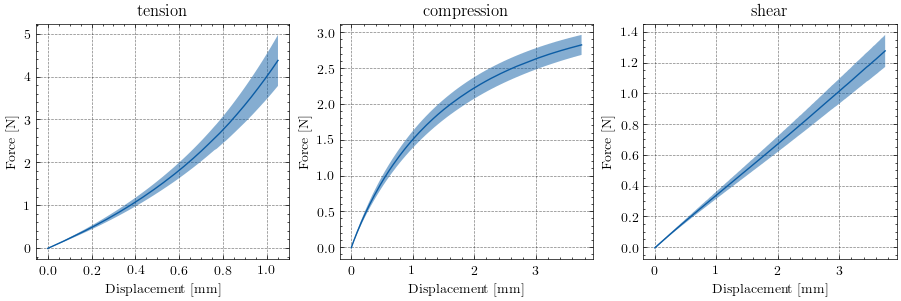

In [42]:
plot_force_displacement_statistics(exp_data, figsize=(9, 3))